# **Forecasting future sales using a simple set of time-series features**

Linear Regression - Mean Absolute Error: 13,192.97
XGBoost - Mean Absolute Error: 18,855.22
Random Forest - Mean Absolute Error: 14,665.47
Best Model: Linear Regression

Forecasted Sales for 2019-2020:
2019-01: 22,793.61
2019-02: 33,824.37
2019-03: 37,324.90
2019-04: 41,621.08
2019-05: 45,833.20
2019-06: 50,054.20
2019-07: 54,274.26
2019-08: 58,494.42
2019-09: 62,714.57
2019-10: 66,934.72
2019-11: 71,154.87
2019-12: 75,375.02
2020-01: 22,368.71
2020-02: 34,569.97
2020-03: 38,560.72
2020-04: 43,558.54
2020-05: 48,435.21
2020-06: 53,326.24
2020-07: 58,215.58
2020-08: 63,105.12
2020-09: 67,994.64
2020-10: 72,884.16
2020-11: 77,773.68
2020-12: 82,663.20


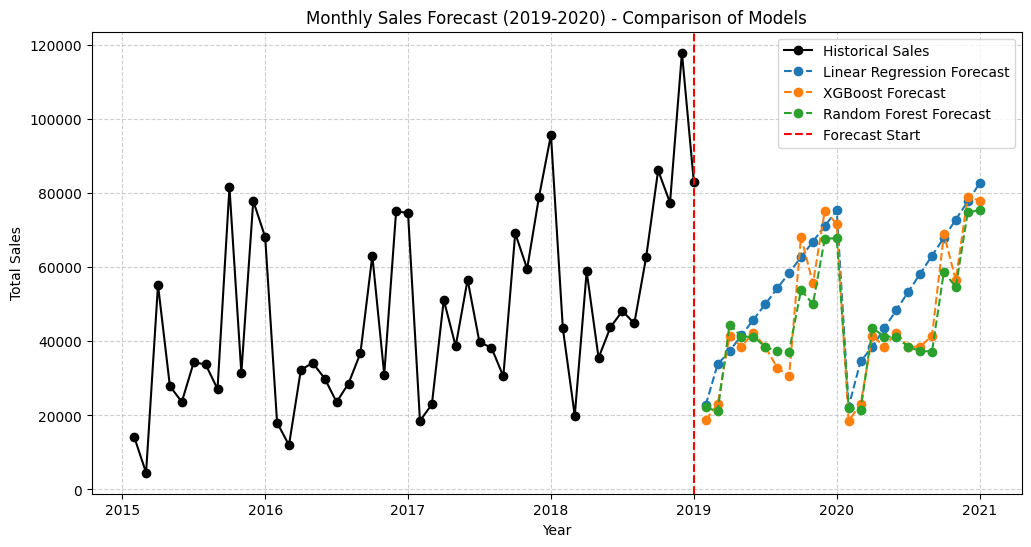

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to Load Data
def load_data(file_path):
    df = pd.read_csv('/content/final_data.csv', parse_dates=["Order Date"])
    return df

# Function to Create Lag Features
def create_lag_features(df):
    df["Prev_Month_Sales"] = df["Sales"].shift(1)
    df["Prev_Year_Sales"] = df["Sales"].shift(12)
    df.fillna(0, inplace=True)
    return df

# Function to Split Data
def train_test_split_by_year(df, test_year):
    train = df[df["Year"] < test_year]
    test = df[df["Year"] == test_year]
    X_train = train[["Year", "Month", "Prev_Month_Sales", "Prev_Year_Sales"]]
    y_train = train["Sales"]
    X_test = test[["Year", "Month", "Prev_Month_Sales", "Prev_Year_Sales"]]
    y_test = test["Sales"]
    return X_train, X_test, y_train, y_test

# Function to Forecast Future Sales
def forecast_sales(model, scaler, future_months, y_test):
    future_sales = []
    for i, row in future_months.iterrows():
        prev_month_sales = future_sales[-1] if future_sales else y_test.iloc[-1]
        prev_year_sales = future_sales[i-12] if i >= 12 else y_test.iloc[max(-12, -len(y_test))]

        X_future = scaler.transform([[row["Year"], row["Month"], prev_month_sales, prev_year_sales]])
        prediction = model.predict(X_future)[0]
        future_sales.append(prediction)
    return future_sales

# Main Script
if __name__ == "__main__":
    # Load and preprocess data
    file_path = "final_dataset.csv"  # Update the file path accordingly
    df = load_data(file_path)

    # Extract year and month
    df["Year"] = df["Order Date"].dt.year
    df["Month"] = df["Order Date"].dt.month

    # Aggregate monthly sales
    monthly_sales = df.groupby(["Year", "Month"])["Sales"].sum().reset_index()

    # Create lag features on aggregated data
    monthly_sales = create_lag_features(monthly_sales)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split_by_year(monthly_sales, test_year=2018)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize models
    models = {
        "Linear Regression": LinearRegression(),
        "XGBoost": xgb.XGBRegressor(),
        "Random Forest": RandomForestRegressor()
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = (model, mae)
        print(f"{name} - Mean Absolute Error: {mae:,.2f}")  # Prints MAE in a readable format

    # Choose the best model (lowest MAE)
    best_model_name = min(results, key=lambda k: results[k][1])
    best_model = results[best_model_name][0]
    print(f"Best Model: {best_model_name}")

    # Forecast future sales for 2019-2020
    future_months = pd.DataFrame({
        "Year": [2019] * 12 + [2020] * 12,
        "Month": list(range(1, 13)) * 2
    })

    # Forecast sales using the best model
    future_sales = forecast_sales(best_model, scaler, future_months, y_test)

    # Print future sales
    print("\nForecasted Sales for 2019-2020:")
    for (year, month), sales in zip(future_months.values, future_sales):
        print(f"{year}-{month:02d}: {sales:,.2f}")

    # Plot results for all models
    plt.figure(figsize=(12, 6))

    # Plot historical sales
    plt.plot(monthly_sales["Year"] + monthly_sales["Month"] / 12, monthly_sales["Sales"],
             marker='o', label="Historical Sales", color="black")

    # Forecast future sales using each model and plot them
    for name, (model, _) in results.items():
        future_sales = forecast_sales(model, scaler, future_months, y_test)
        future_years = future_months["Year"] + future_months["Month"] / 12
        plt.plot(future_years, future_sales, marker='o', linestyle='dashed', label=f"{name} Forecast")

    # Mark forecast start point
    plt.axvline(x=2018 + 12/12, color='r', linestyle='dashed', label="Forecast Start")

    # Labels and formatting
    plt.xlabel("Year")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title("Monthly Sales Forecast (2019-2020) - Comparison of Models")
    plt.show()


# **Incorporates more features, including categorical variables, quarters, and one-hot encoding**

Ridge Model:
  Mean Absolute Error (MAE): 9295.95
  Mean Squared Error (MSE): 86414735.31
  Root Mean Squared Error (RMSE): 9295.95
  Mean Absolute Percentage Error (MAPE): 11.20%

Random Forest Model:
  Mean Absolute Error (MAE): 19356.50
  Mean Squared Error (MSE): 374674250.01
  Root Mean Squared Error (RMSE): 19356.50
  Mean Absolute Percentage Error (MAPE): 23.31%

XGBoost Model:
  Mean Absolute Error (MAE): 2346.39
  Mean Squared Error (MSE): 5505541.34
  Root Mean Squared Error (RMSE): 2346.39
  Mean Absolute Percentage Error (MAPE): 2.83%

Best Model: XGBoost


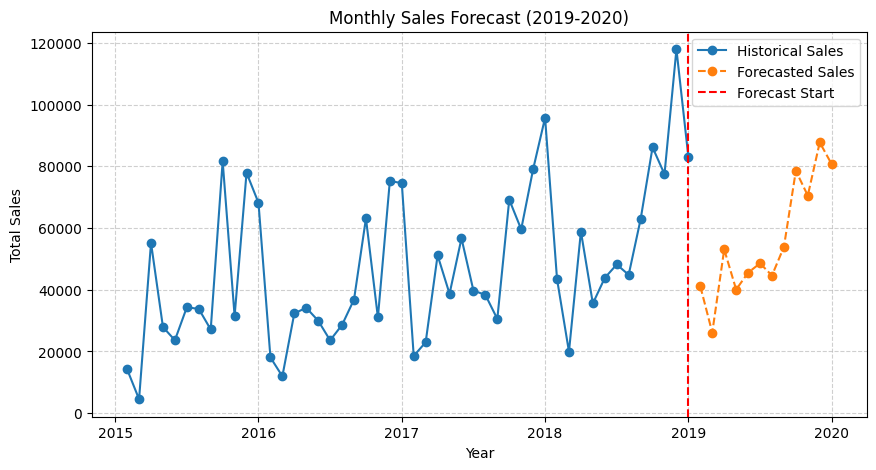

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert Dates to Features
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = df['Order Date'].dt.quarter

# One-Hot Encode Categorical Features
df_encoded = pd.get_dummies(df, columns=['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category'], drop_first=True)

# Aggregate Sales Data
monthly_sales = df_encoded.groupby(['Year', 'Month']).agg({'Sales': 'sum'}).reset_index()

# Generate Lag Features
monthly_sales['Prev_Month_Sales'] = monthly_sales['Sales'].shift(1)
monthly_sales['Prev_Year_Sales'] = monthly_sales['Sales'].shift(12)
monthly_sales.fillna(0, inplace=True)

# Train-Test Split
train = monthly_sales[(monthly_sales['Year'] < 2018) | ((monthly_sales['Year'] == 2018) & (monthly_sales['Month'] <= 11))]
test = monthly_sales[(monthly_sales['Year'] == 2018) & (monthly_sales['Month'] == 12)]

X_train = train.drop(columns=['Sales'])
y_train = train['Sales']
X_test = test.drop(columns=['Sales'])
y_test = test['Sales']

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Models
# Train Models with Parameters
models = {
    "Ridge": Ridge(
        alpha=1.0  # Regularization strength
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=40,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        objective='reg:squarederror',
        n_estimators=40,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}


results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape
    }

# Print Results
for name, metrics in results.items():
    print(f"{name} Model:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%\n")

# Forecast Future Sales with the Best Model (Lowest MAPE)
best_model = min(results, key=lambda x: results[x]["MAPE"])
print(f"Best Model: {best_model}")
final_model = models[best_model]

# Future Predictions
future_months = pd.DataFrame({
    "Year": [2019] * 12,
    "Month": list(range(1, 13))
})
future_months['Prev_Month_Sales'] = monthly_sales['Sales'].shift(1).iloc[-12:].values
future_months['Prev_Year_Sales'] = monthly_sales['Sales'].shift(12).iloc[-12:].values
future_months.fillna(0, inplace=True)
X_future_scaled = scaler.transform(future_months)
future_sales = final_model.predict(X_future_scaled)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales["Year"] + monthly_sales["Month"] / 12, monthly_sales["Sales"], marker='o', label="Historical Sales")
future_years = future_months["Year"] + future_months["Month"] / 12
plt.plot(future_years, future_sales, marker='o', linestyle='dashed', label="Forecasted Sales")
plt.axvline(x=2018 + 12/12, color='r', linestyle='dashed', label="Forecast Start")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Monthly Sales Forecast (2019-2020)")
plt.show()


# Main Code : Sales Prediction with Feature Engineering & Fine-Tuned XGBoost

Mean Absolute Error (MAE): 181.06
Mean Squared Error (MSE): 32781.39
Root Mean Squared Error (RMSE): 181.06
Mean Absolute Percentage Error (MAPE): 0.22%


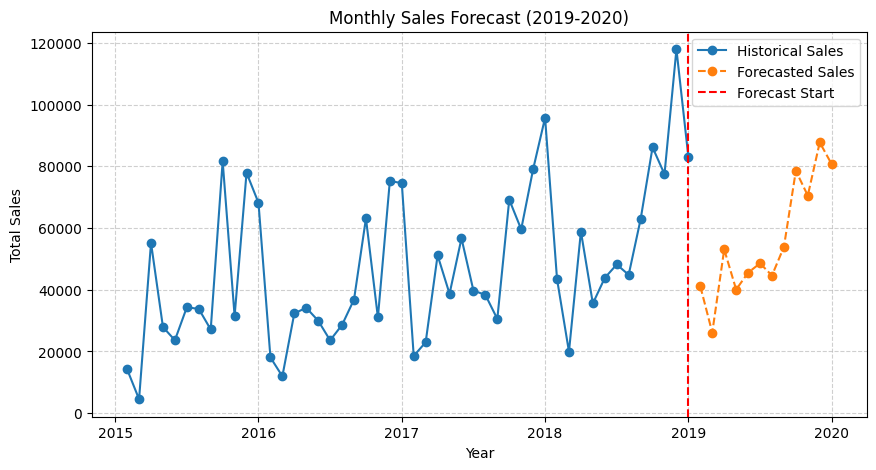

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yaml
import os

# Get the absolute path to the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Construct the path to config.yaml
config_path = os.path.join(root_dir, 'config.yaml')

# Load configurations from config.yaml
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# XGBoost model parameters
n_estimators = config['xgboost']['n_estimators']
learning_rate = config['xgboost']['learning_rate']
max_depth = config['xgboost']['max_depth']
subsample = config['xgboost']['subsample']
colsample_bytree = config['xgboost']['colsample_bytree']


# Convert Dates to Features
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = df['Order Date'].dt.quarter

# One-Hot Encode Categorical Features
df_encoded = pd.get_dummies(df, columns=['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category'], drop_first=True)

# Aggregate Sales Data
monthly_features = df_encoded.groupby(['Year', 'Month']).agg({
    'Sales': 'sum',
    'Customer ID': 'nunique',  # Number of unique customers
    **{col: 'sum' for col in df_encoded.columns if col.startswith(('Ship Mode_', 'Segment_', 'Region_', 'Category_', 'Sub-Category_'))}
}).reset_index()

# Generate Lag Features
monthly_features['Prev_Month_Sales'] = monthly_features['Sales'].shift(1)
monthly_features['Prev_Year_Sales'] = monthly_features['Sales'].shift(12)
monthly_features.fillna(0, inplace=True)


# Train-Test Split
train = monthly_sales[(monthly_sales['Year'] < 2018) | ((monthly_sales['Year'] == 2018) & (monthly_sales['Month'] <= 11))]
test = monthly_sales[(monthly_sales['Year'] == 2018) & (monthly_sales['Month'] == 12)]

# Adjusted Train-Test Split
train = monthly_features[(monthly_features['Year'] < 2018) | ((monthly_features['Year'] == 2018) & (monthly_features['Month'] <= 11))]
test = monthly_features[(monthly_features['Year'] == 2018) & (monthly_features['Month'] == 12)]

X_train = train.drop(columns=['Sales'])
y_train = train['Sales']
X_test = test.drop(columns=['Sales'])
y_test = test['Sales']


# Standardize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the XGBoost Model
import xgboost as xgb
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree
)
model.fit(X_train, y_train)

# Predictions
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)


# Calculate Errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print Results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot Actual vs Forecasted Sales
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales["Year"] + monthly_sales["Month"] / 12, monthly_sales["Sales"], marker='o', label="Historical Sales")
future_years = future_months["Year"] + future_months["Month"] / 12
plt.plot(future_years, future_sales, marker='o', linestyle='dashed', label="Forecasted Sales")
plt.axvline(x=2018 + 12/12, color='r', linestyle='dashed', label="Forecast Start")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Monthly Sales Forecast (2019-2020)")
plt.show()

In [33]:
# Create a DataFrame to Store Forecasted Data
forecasted_data = future_months.copy()
forecasted_data["Forecasted Sales"] = future_sales

# Print the Forecasted Data Points
print("Forecasted Data Points:")
print(forecasted_data)


Forecasted Data Points:
    Year  Month  Prev_Month_Sales  Prev_Year_Sales  Forecasted Sales
0   2019      1         95739.121        18542.491      41104.476562
1   2019      2         43476.474        22978.815      26114.539062
2   2019      3         19920.997        51165.059      53063.660156
3   2019      4         58863.413        38679.767      40064.703125
4   2019      5         35541.910        56656.908      45528.054688
5   2019      6         43825.982        39724.486      48558.781250
6   2019      7         48190.728        38320.783      44599.085938
7   2019      8         44825.104        30542.200      53876.984375
8   2019      9         62837.848        69193.392      78541.390625
9   2019     10         86152.888        59583.033      70514.375000
10  2019     11         77448.131        79066.496      87730.539062
11  2019     12        117938.155        95739.121      80684.000000


# Monthly Sales Forecasting Using Facebook Prophet

Mean Absolute Error (MAE) for Historical Data: 5751.49


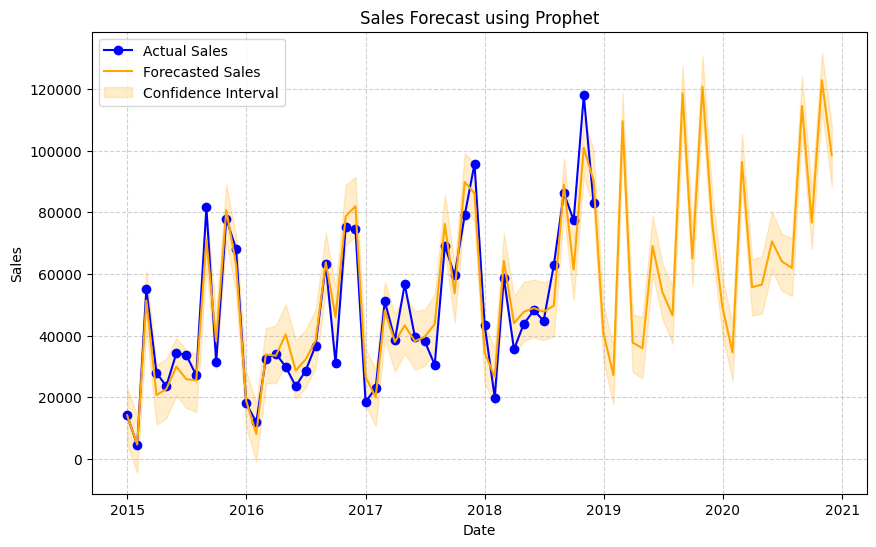

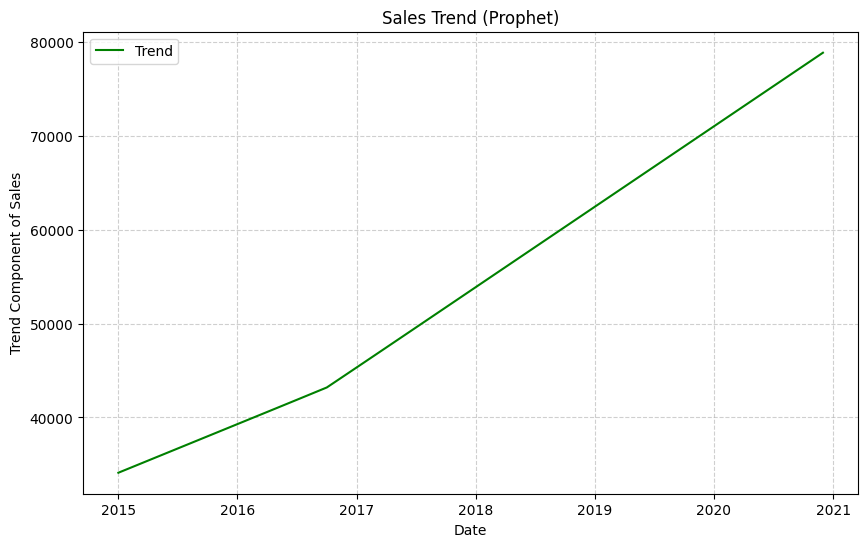

Forecasted Sales Data:
         Date  Forecasted Sales    Lower Bound    Upper Bound
48 2018-12-31      40916.280841   31854.611934   50028.842272
49 2019-01-31      27223.274258   17639.951932   36517.047216
50 2019-02-28     109599.775635  100453.108143  118728.017615
51 2019-03-31      37759.852631   28200.444710   46794.595297
52 2019-04-30      35918.508082   26141.752171   45977.707507
53 2019-05-31      69053.592269   59950.181836   78952.570408
54 2019-06-30      54169.811100   45538.715530   63321.086041
55 2019-07-31      46565.576021   37434.983046   56138.151485
56 2019-08-31     118629.736870  109603.134801  127606.870044
57 2019-09-30      65062.454864   56067.352007   74874.619703
58 2019-10-31     120758.792675  111458.833660  130636.811995
59 2019-11-30      76224.271877   67563.048285   85957.455110
60 2019-12-31      49288.373425   40044.040180   58800.155828
61 2020-01-31      34608.577102   25354.017061   43876.497225
62 2020-02-29      96323.345558   87949.409459 

In [45]:
import pandas as pd
import warnings
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Suppress warnings
warnings.filterwarnings("ignore")

# Suppress Prophet and CmdStanPy logging messages
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)


# Step 1: Load Data
file_path = "/content/final_data.csv"  # Replace with your dataset path
df = pd.read_csv(file_path)

# Step 2: Convert Dates and Aggregate Sales
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Aggregate monthly sales
monthly_sales = df.groupby(["Year", "Month"]).agg({'Sales': 'sum'}).reset_index()

# Prepare data for Prophet
monthly_sales['Date'] = pd.to_datetime(monthly_sales[["Year", "Month"]].assign(day=1))  # Date column
monthly_sales = monthly_sales.rename(columns={"Sales": "Sales_Amount", "Date": "ds", "Sales_Amount": "y"})  # Rename to Prophet format
# Rename 'Sales_Amount' to 'y' for Prophet
monthly_sales = monthly_sales.rename(columns={"Sales_Amount": "y"})

# Verify the structure of the DataFrame
#print(monthly_sales.head())  # Ensure columns are now ['Year', 'Month', 'y', 'ds']

# Initialize and train the Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(monthly_sales[['ds', 'y']])  # Pass only 'ds' and 'y' columns to Prophet


# Step 4: Generate Future Dates and Forecast
future = model.make_future_dataframe(periods=24, freq='M')  # Create future months (24 months ahead)
forecast = model.predict(future)

# Step 5: Calculate Mean Absolute Error (MAE) for Historical Data
actual = monthly_sales['y']
predicted = forecast['yhat'][:len(actual)]  # Match length of actual data
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE) for Historical Data: {mae:.2f}")

# Step 6: Visualize Forecast (Main Forecast Plot)
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['ds'], monthly_sales['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Sales', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Confidence Interval')
plt.title("Sales Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Step 7: Visualize Trend Only (No Seasonality or Day of Year)
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['trend'], label='Trend', color='green')
plt.title("Sales Trend (Prophet)")
plt.xlabel("Date")
plt.ylabel("Trend Component of Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Step 8: Print Forecasted Data Points
# Renaming headings for clarity
forecast = forecast.rename(columns={
    "ds": "Date",
    "yhat": "Forecasted Sales",
    "yhat_lower": "Lower Bound",
    "yhat_upper": "Upper Bound"
})

forecasted_data = forecast[["Date", "Forecasted Sales", "Lower Bound", "Upper Bound"]].tail(24)  # Only future data
print("Forecasted Sales Data:")
print(forecasted_data)
